# CASESTUDY 5 
### BASEBALL SALARY PREDICTION

In [57]:
#importing libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score,roc_curve
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression



In [58]:
# load dataset:

data=pd.read_csv("datasets//hitters.csv")
df=data.copy()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


![img](data_content.png)

### EDA

In [59]:
print('Shape of the data:',df.shape)
print("****************************")
print('Columns of the data:',df.columns)
print("****************************")
print('Number of unique values:',df.nunique())
print("****************************")
print('Number of duplicated values:',df.duplicated().sum())

Shape of the data: (322, 20)
****************************
Columns of the data: Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')
****************************
Number of unique values: AtBat        247
Hits         144
HmRun         36
Runs          96
RBI          103
Walks         89
Years         22
CAtBat       314
CHits        288
CHmRun       146
CRuns        261
CRBI         262
CWalks       248
League         2
Division       2
PutOuts      232
Assists      161
Errors        29
Salary       150
NewLeague      2
dtype: int64
****************************
Number of duplicated values: 0


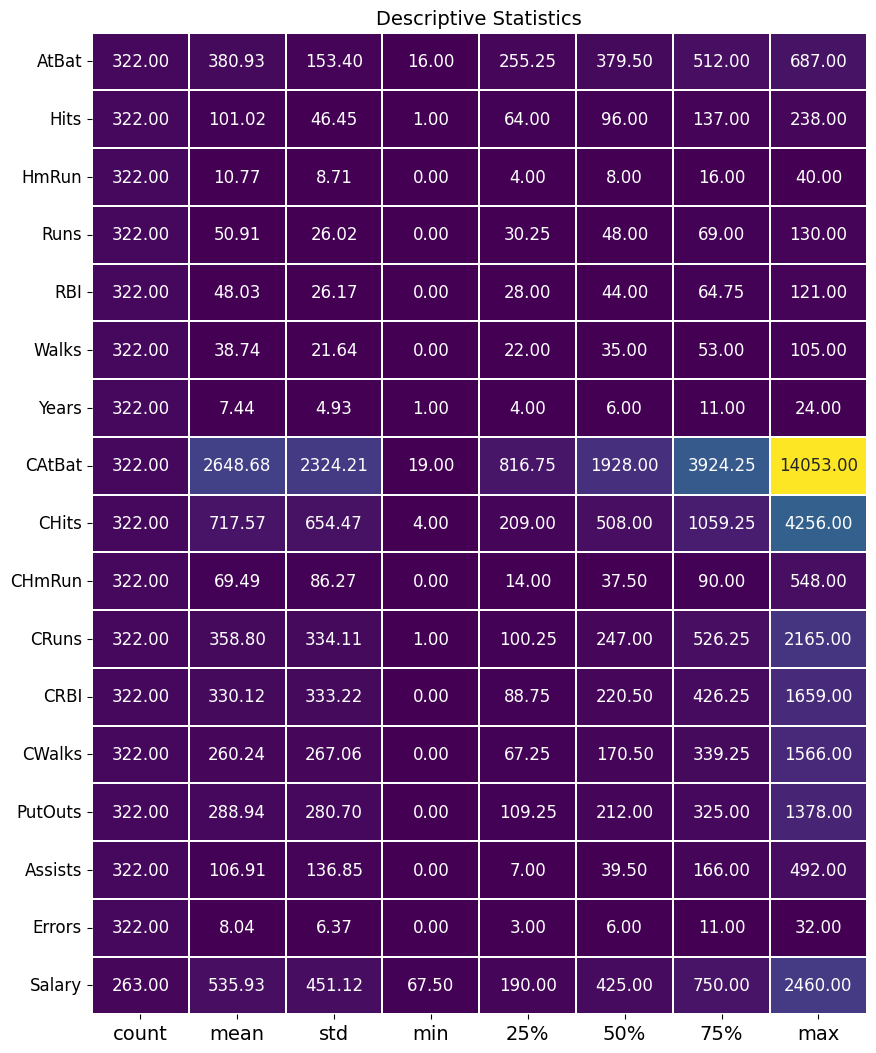

In [60]:
# describe the data
cols=df.select_dtypes(include=['float64','int64'])
cmap1 = 'viridis'
def desc_stats(dataframe):
    desc = dataframe.describe().T
    f,ax = plt.subplots(figsize=(10,
                                 desc.shape[0] * 0.75))
    sns.heatmap(desc,
                annot = True,
                cmap = cmap1,
                fmt= '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.3,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 14)
    plt.yticks(size = 12,
               rotation = 0)

    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(cols)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [62]:
data=df.iloc[:,0:78]
nums=data.select_dtypes(include=['float64','int64']).drop(['Salary'], axis=1).columns
def target_summary_nums(df, target, nums):
    for i in nums:
        print(df.groupby(target).agg({i: ['mean', 'median', 'std', 'count']}))
        print('\n')
   

target_summary_nums(df, 'Salary', nums)

          AtBat                        
           mean median        std count
Salary                                 
67.500    181.0  181.0        NaN     1
68.000    209.0  209.0        NaN     1
70.000    248.6  215.0  61.378335     5
75.000    236.4  216.0  63.693014     5
80.000    399.0  399.0        NaN     1
...         ...    ...        ...   ...
1940.000  514.0  514.0        NaN     1
1975.000  677.0  677.0        NaN     1
2127.333   20.0   20.0        NaN     1
2412.500  618.0  618.0        NaN     1
2460.000  495.0  495.0        NaN     1

[150 rows x 4 columns]


           Hits                        
           mean median        std count
Salary                                 
67.500     41.0   41.0        NaN     1
68.000     54.0   54.0        NaN     1
70.000     57.4   53.0  15.915401     5
75.000     58.2   54.0  15.546704     5
80.000    102.0  102.0        NaN     1
...         ...    ...        ...   ...
1940.000  144.0  144.0        NaN     1
1975.000  238.

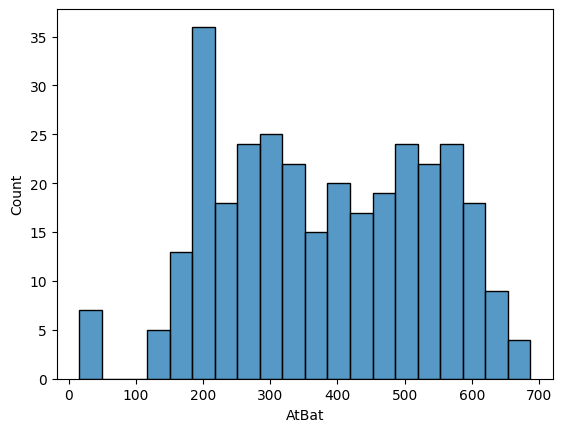

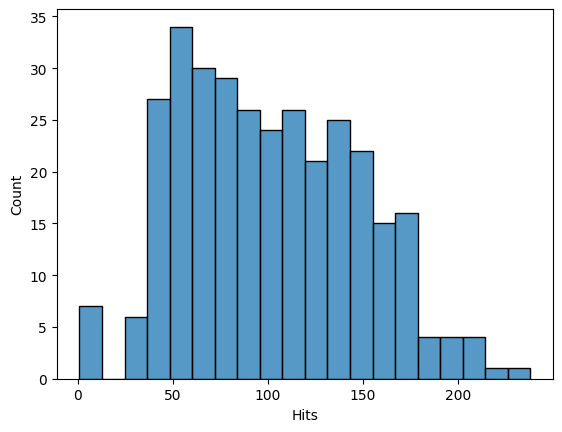

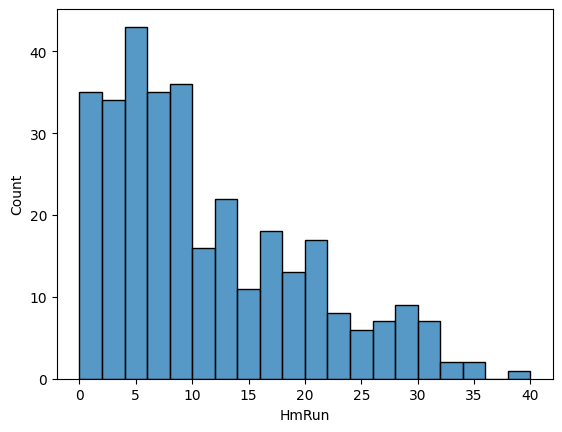

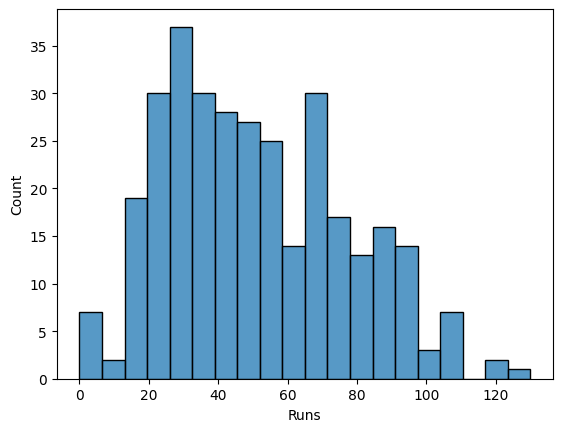

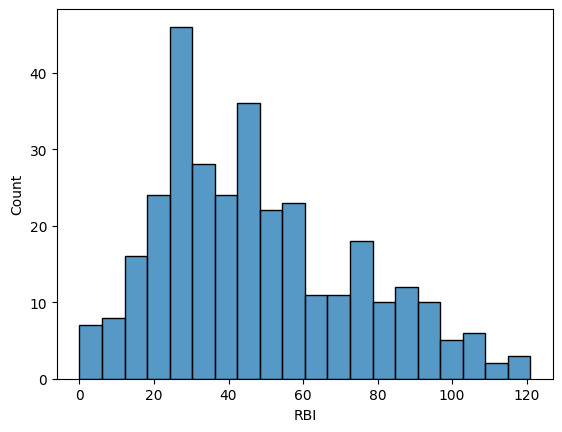

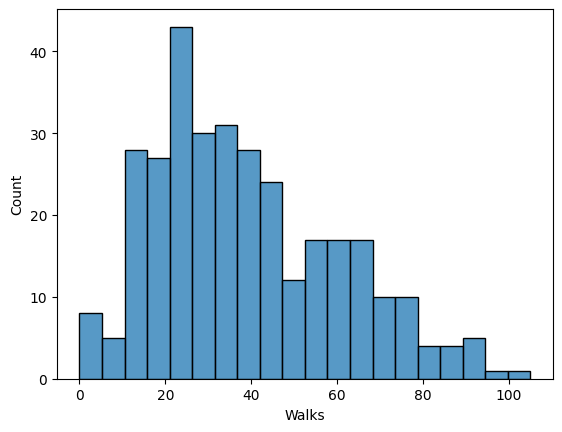

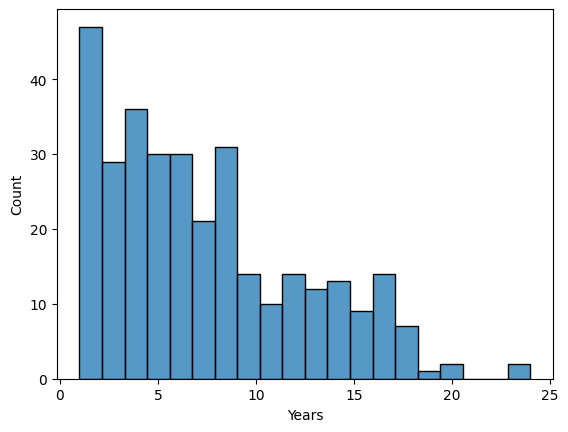

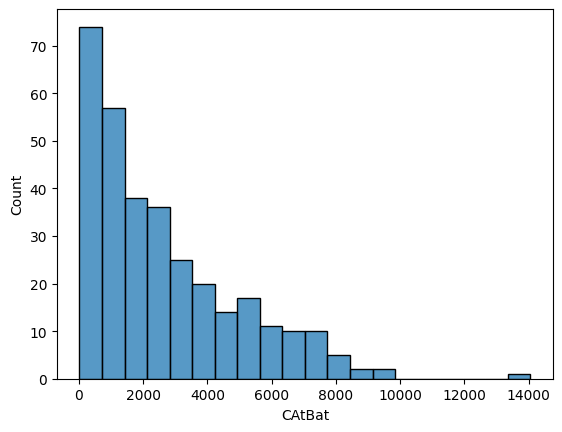

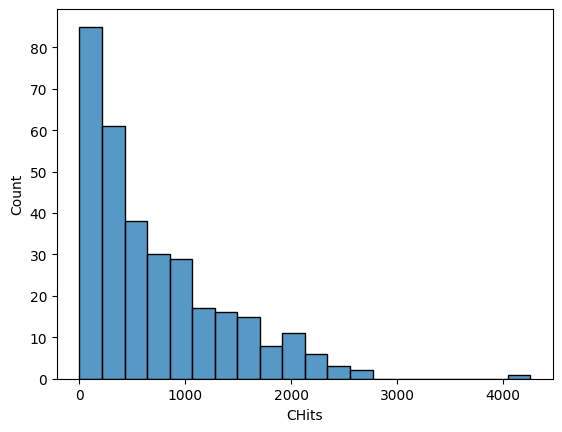

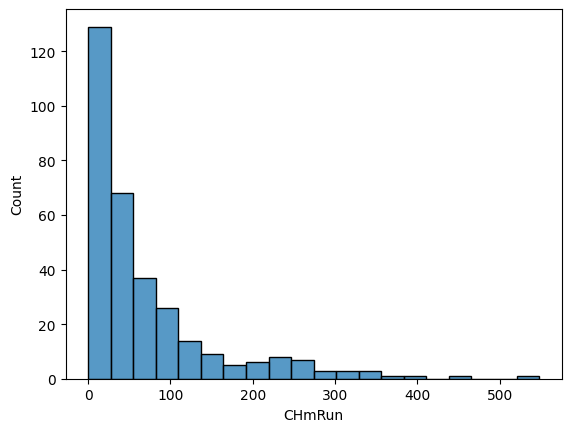

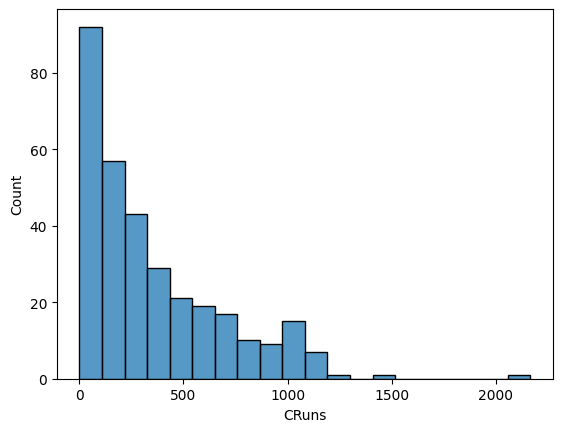

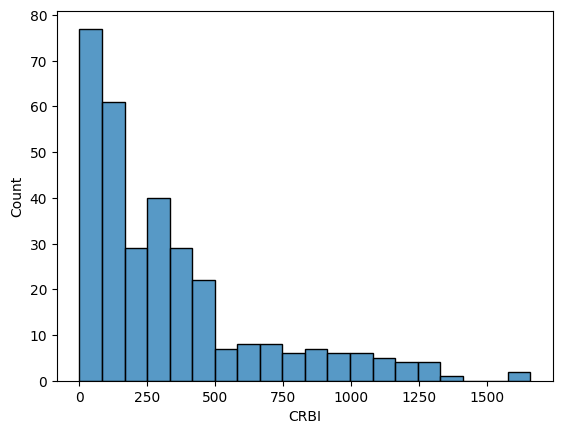

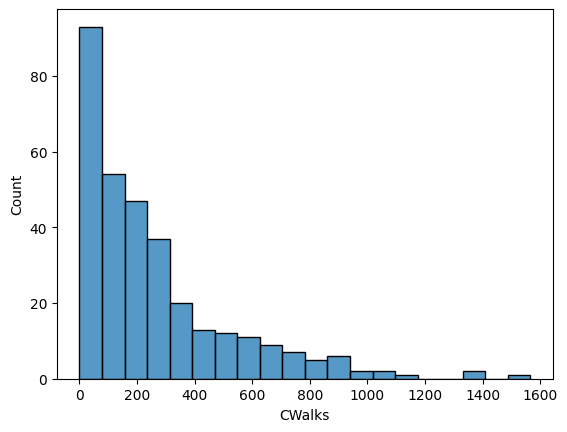

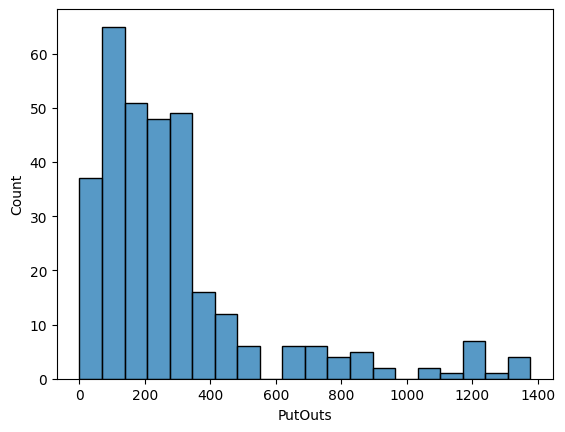

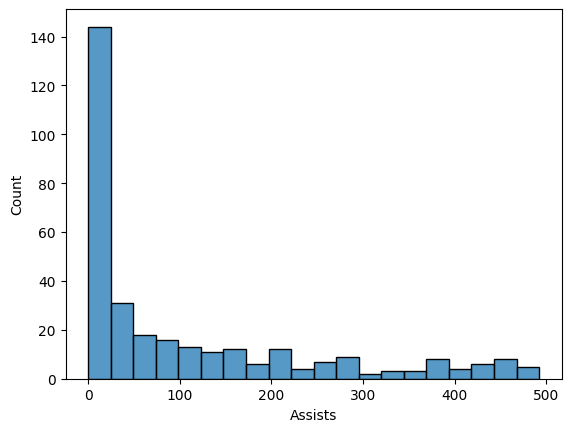

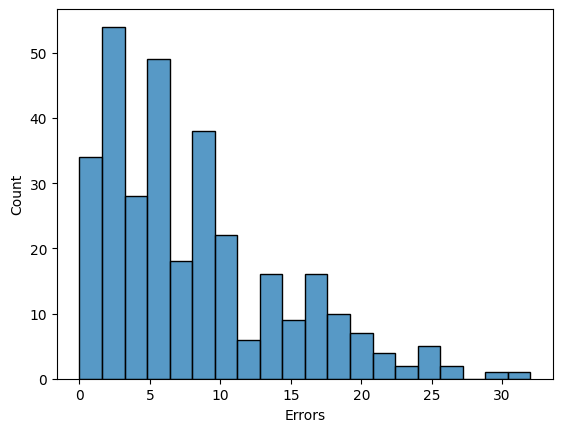

In [63]:

nums=df.select_dtypes(include=['float64','int64']).drop(['Salary'], axis=1).columns
def plot_numerical_cols(df, numerical_cols):
    for col in numerical_cols:
        sns.histplot(df[col], bins=20)
        plt.xlabel(col)
        plt.show(block=True)
plot_numerical_cols(df, nums)

In [64]:
# show the missing values in dataset with ratio
def missing_values_tabl(df):
    
    na_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio,2)], axis=1, keys=['n_miss', 'ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

missing_values_tabl(df)

,n_miss,ratio
Salary,59,18.32


In [65]:
# filling missing values KNNImputer

from sklearn.impute import KNNImputer

knn=KNNImputer(n_neighbors=5)

df["Salary"]=knn.fit_transform(df[["Salary"]])

df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,535.925882,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500000,N


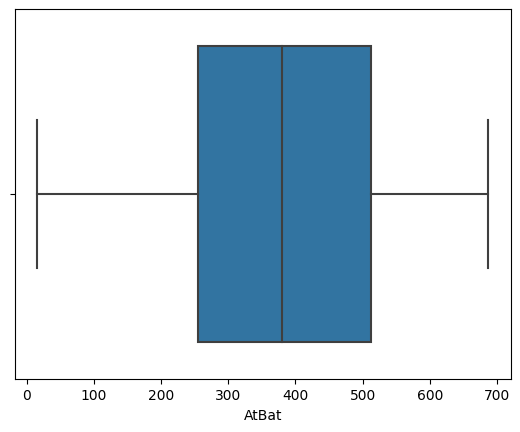

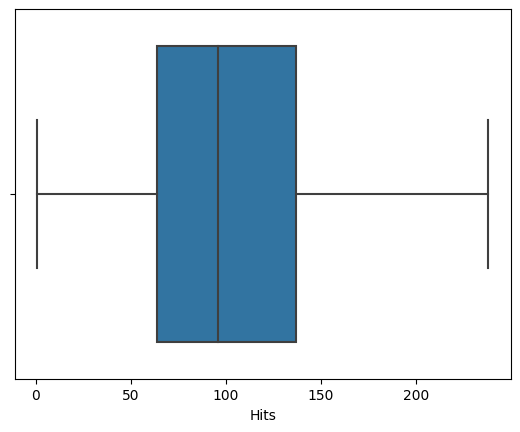

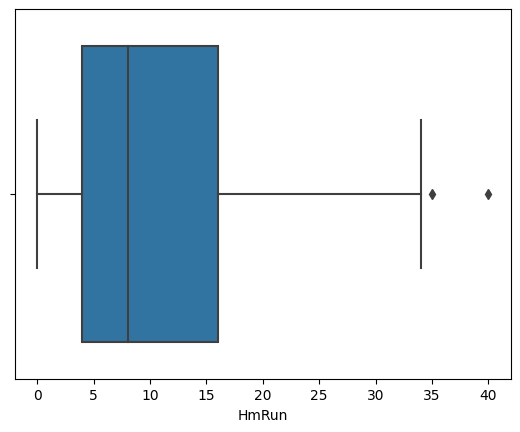

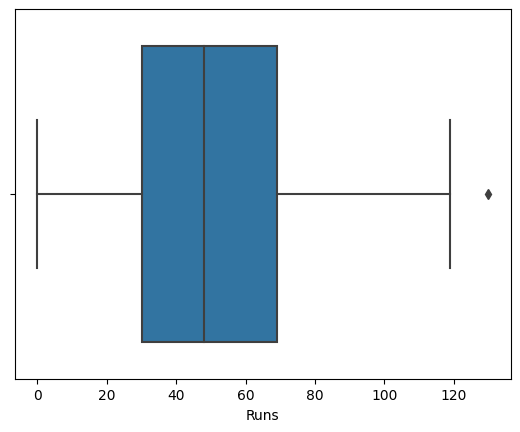

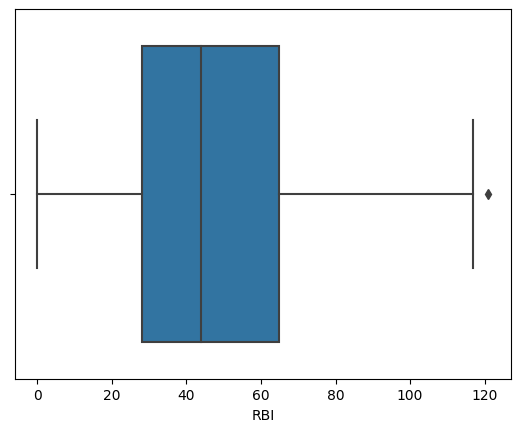

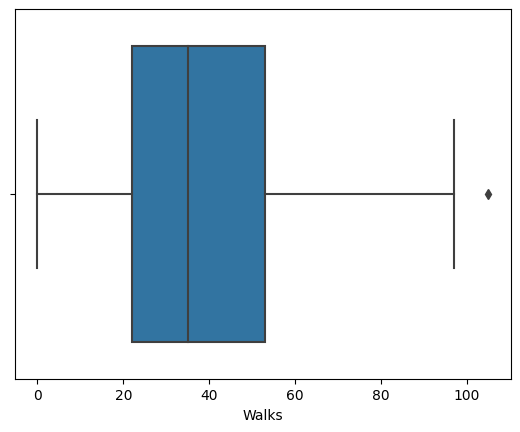

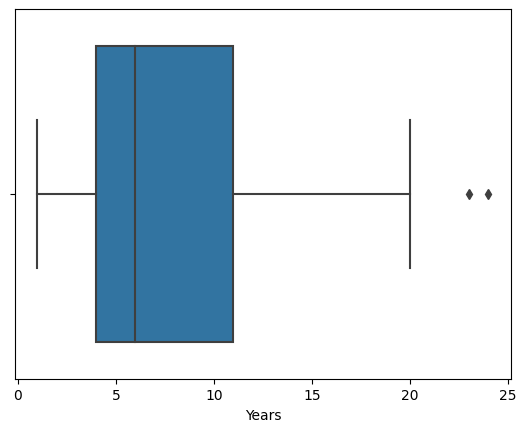

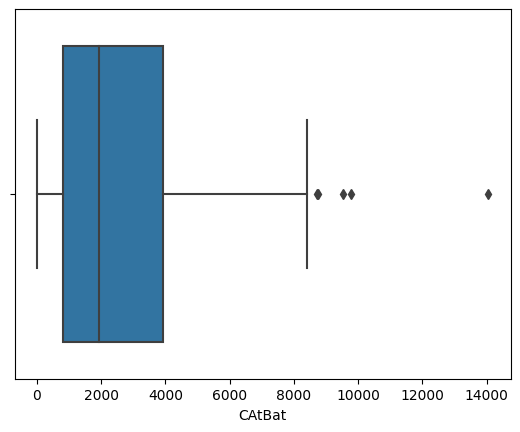

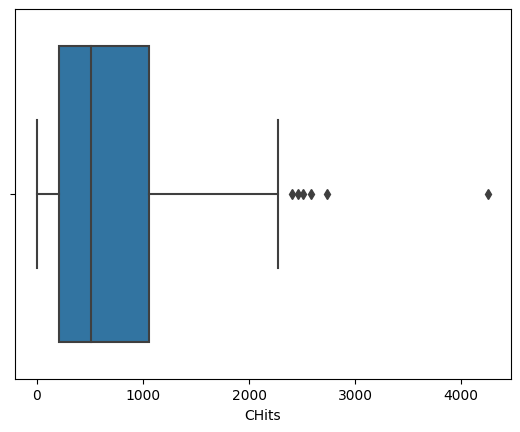

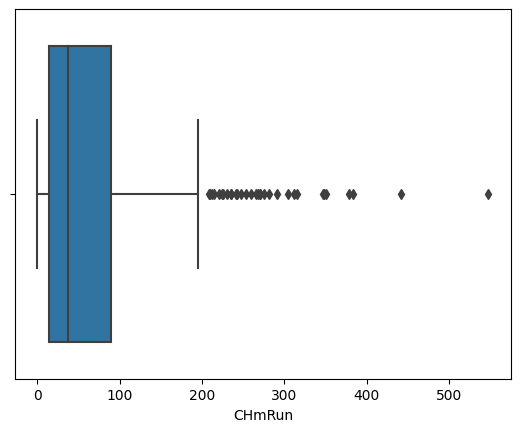

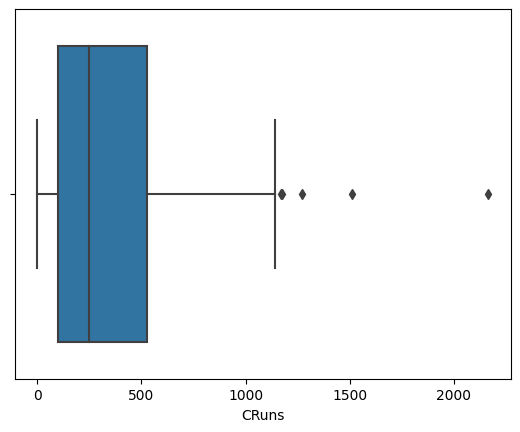

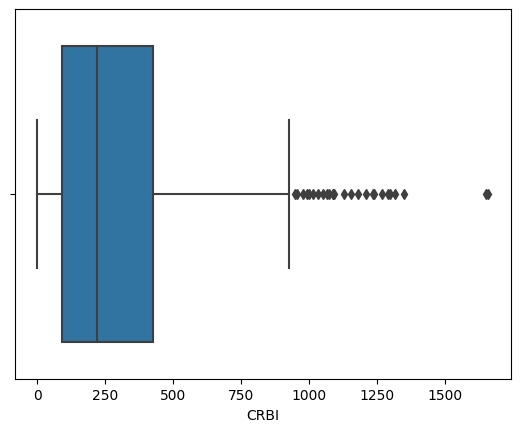

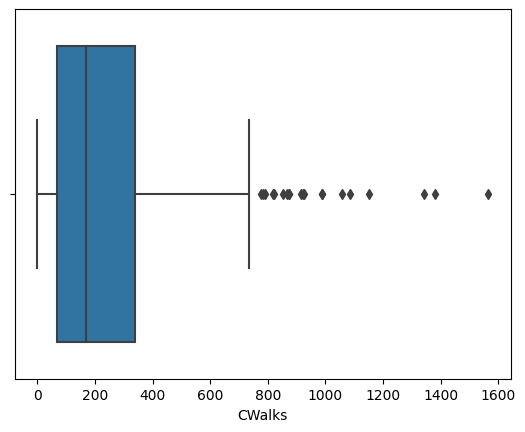

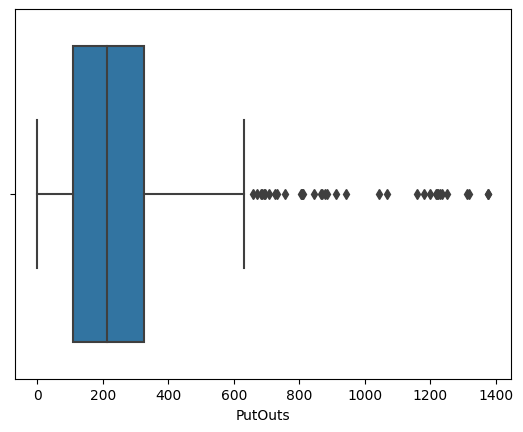

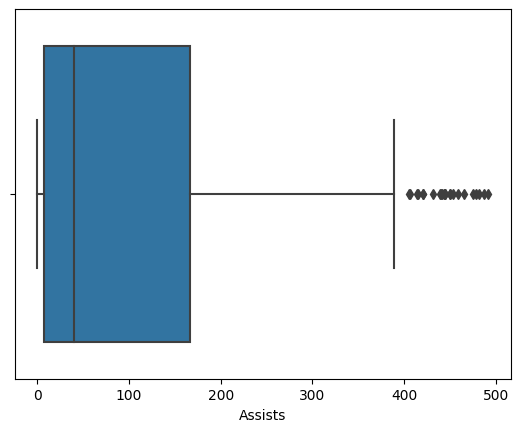

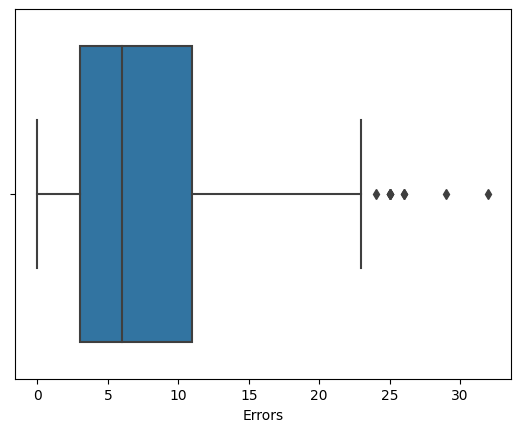

In [66]:
nums=df.select_dtypes(include=['float64','int64']).drop(['Salary'], axis=1).columns

for i in nums:
    sns.boxplot(x=df[i])
    plt.xlabel(i)
    plt.show() 

In [67]:
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    q1=dataframe[col_name].quantile(q1)
    q3=dataframe[col_name].quantile(q3)
    IQR=q3-q1
    
    up_limit=q3+1.5*IQR
    low_limit=q1-1.5*IQR
    
    return low_limit,up_limit

def check_outliers(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name]<low_limit) | (dataframe[col_name]>up_limit)].any(axis=None):
        return True 
   
    else:
        return False

def replace_with_thresholds(dataframe, col):
    low_limit, up_limit = outlier_thresholds(dataframe, col)
    if low_limit > 0:
        dataframe.loc[(dataframe[col] < low_limit), col] = low_limit
        dataframe.loc[(dataframe[col] > up_limit), col] = up_limit
    else:
        dataframe.loc[(dataframe[col] > up_limit), col] = up_limit
    
for col in nums:
    replace_with_thresholds(df,col)
    
print("After filling with thresholds:")
for col in nums:
    print(col,check_outliers(df,col))
print(df.shape)


After filling with thresholds:
AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
(322, 20)


In [68]:
# label encoder:

cats=df.select_dtypes(include=["object","bool","category"]).columns
cats

for i in cats:
    print(i,":",len(df[i].unique()),"labels")


League : 2 labels
Division : 2 labels
NewLeague : 2 labels


In [69]:
def label_encoder(df, column_name):
    if df[column_name].dtype == 'object':
        if df[column_name].nunique() <= 2:
            le = LabelEncoder()
            df[column_name] = le.fit_transform(df[column_name])
            return df
        elif df[column_name].nunique() > 2  and df[column_name].nunique() <= 10:
            ohe = OneHotEncoder()
            ohe_df = pd.DataFrame(ohe.fit_transform(df[[column_name]]).toarray())
            ohe_df.columns = [column_name + "_" + str(i) for i in ohe_df.columns]
            df = df.join(ohe_df)
            df = df.drop(column_name, axis=1)
            return df
        else:
            return df
        
    else:
        return df
    
    
for i in cats:
    df = label_encoder(df, i)
    
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293.0,66.0,1,30.0,29.0,14.0,1.0,293.0,66.0,1,30.0,29.0,14.0,0,0,446.000,33.0,20,535.925882,0
1,315.0,81.0,7,24.0,38.0,39.0,14.0,3449.0,835.0,69,321.0,414.0,375.0,1,1,632.000,43.0,10,475.000000,1
2,479.0,130.0,18,66.0,72.0,76.0,3.0,1624.0,457.0,63,224.0,266.0,263.0,0,1,648.625,82.0,14,480.000000,0
3,496.0,141.0,20,65.0,78.0,37.0,11.0,5628.0,1575.0,204,828.0,838.0,354.0,1,0,200.000,11.0,3,500.000000,1
4,321.0,87.0,10,39.0,42.0,30.0,2.0,396.0,101.0,12,48.0,46.0,33.0,1,0,648.625,40.0,4,91.500000,1


In [70]:
X=df.drop("Salary",axis=1).values
y=df["Salary"].values.reshape(-1,1)

In [71]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (257, 19)
y_train shape: (257, 1)
X_test shape: (65, 19)
y_test shape: (65, 1)


In [79]:
# regression algorithms

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None

lr=LinearRegression()
svr=SVR()
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
gr=GradientBoostingRegressor()
knn=KNeighborsRegressor()
ml=MLPRegressor()


models = [ lr, svr, dt, rf, gr, knn, ml]
overral=pd.DataFrame(columns=["Model","R2 Score",
                              "Cross Val Score","RMSE","MAE","MSE"])
for model in models:
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    cv=cross_val_score(model,X,y,cv=10).mean()
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    mae=mean_absolute_error(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    
    overral=overral.append({"Model":model.__class__.__name__,
                            "R2 Score":r2,
                            "Cross Val Score":cv,
                            "RMSE":rmse,
                            "MAE":mae,
                            "MSE":mse},ignore_index=True)
    

overral=overral.sort_values(by="RMSE",ascending=False)
overral=overral.style.background_gradient(cmap="Blues")
overral

,Model,R2 Score,Cross Val Score,RMSE,MAE,MSE
1,SVR,0.025632,0.021855,428.312721,263.382908,183451.786658
2,DecisionTreeRegressor,0.105099,-0.179893,410.475206,271.597992,168489.894399
5,KNeighborsRegressor,0.338254,0.270060,352.975929,223.458007,124592.006692
0,LinearRegression,0.353624,0.266897,348.852625,242.838560,121698.153677
4,GradientBoostingRegressor,0.456585,0.400111,319.863949,216.744940,102312.945938
6,MLPRegressor,0.531436,0.349936,297.018890,186.084664,88220.220807
3,RandomForestRegressor,0.549712,0.442861,291.168782,197.808924,84779.259795
